# PyroPDMP 
PyroPDMP is a Python repository that integrates the simulation of Piece-wise Deterministic Markov Processes in the library [Pyro](https://github.com/pyro-ppl/pyro), that allows to define Probabilistic models easily. More importantly, it is built on [PyTorch](https://pytorch.org) which enables to user to define an optimise complicated models in a simple way. 

This notebook attempts to introduce how to use these codes to easily define Bayesian models and sample from their posterior distributions using PDMPs without the need to especify explicitly a target distribution or its gradient. Several simple examples will be used for this putpose. 

Codes implementing the PDMP algorithms are written in separated scripts, they all inherite from the MCMC class in Pyro that allows to simulate Markov Chain given a pre-defined Kernel. 

# Importation
These are the requirements that the codes will need. 


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Dissertation/PyroKernels/')

In [ ]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install progress

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9632 sha256=f130e90db8dc8ecab77b92d794a0a591b4b97a726a11aeb45434b46ae35740c6
  Stored in directory: /root/.cache/pip/wheels/8e/d7/61/498d8e27dc11e9805b01eb3539e2ee344436fc226daeb5fe87
Successfully built progress


In [ ]:
from Pyro_Boomerang import Boomerang
from Pyro_Zigzag import ZZ
from Pyro_BPS import BPS
from utils import *

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
import torch 
import pyro 
import pyro.distributions as dist
from pyro.infer import MCMC

# Bayesian Linear Regression 

This simple Bayesian Linear Regression with Gaussian priors will provide a first insight on the usage. 

## Data generation
Here some synthetic data is generated for simplicity. Note that it is much more convinient for further purposes to use torch from the very beginning and avoid numpy as much as possible. This is because Pyro is built on PyTorch, that is not compatible with numpy and at some point traslation to Torch tensors will be needed for any numpy object. 

For this example we generate 1000 samples from a 10-dimensional standard gaussian distribution and define a true model. Subsequently, white noise is introduced to the model to make it more realistic. 

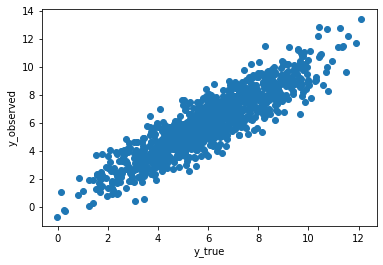

In [ ]:
true_coefs = torch.tensor([1., 2., 1., 2.3, -2.1, 5., 1., 1., -2., 3.])
dim = 10
x = torch.rand(1000, dim)
y_true = torch.matmul(x, true_coefs)
sigma = 1
labels = y_true + torch.normal(0, sigma, size = (1, 1000))

plt.scatter(y_true, labels.squeeze())
plt.xlabel("y_true")
plt.ylabel("y_observed")
plt.show()

## Definition of the model. 
In this section the workflow of the model needs to be defined. In this simple example it follows directly from the skeleton of the Bayesian model: 
$$Y\sim\mathcal{N}(\beta^T x, \sigma)$$
$$\beta\sim\mathcal{N}(0,I_{10})$$ 
with some fixed variance parametre. 

The definition of the model is not specific of this repository but directly uses models defined on Pyro. Essentialy, in this part you need to define some structure that represents the model, in this case a function that receives data and outputs the probability under the likelihood of the model, where the parametres follow a standard normal distribution. 

In [ ]:
def model(data):
     coefs_mean = torch.zeros(dim)
     coefs_var = torch.ones(dim)
     coefs = pyro.sample('beta', dist.Normal(coefs_mean, coefs_var))
     y = pyro.sample('y', dist.Normal((coefs * data).sum(-1), sigma), obs=labels)
     return y

## Reference Measure
Recall that the Boomerang Sampler operates on some Gaussian reference measure that needs to be defined. To make things easy we will assume for now no pre-existing knowledge on the posterior and define the variance of the reference to be de indentity and its mode the origin (note that the choice of the origin for the mode is the default one in the kernels). 
$$\mu_0= \mathcal{N}(0, I_{10})\otimes\mathcal{N}(0, I_{10})$$

In [ ]:
"REFERENCE MEASURE TUNING"
Sigma_ref = torch.eye(dim)
Sigma_ref_inv = Sigma_ref

## Definition of the Sampler 
To define the process that we will be simulating several quantities need to be chosen. This is done by creating an instance of the class 'Boomerang'. 

First, since the Hessian for this problem is known and constant the Dominated-Hessian strategy is easy to implement and thus will be used here. The argument *ihpp_sampler = 'Exact'* determines this. To use this strategy the kernel needs to receive a bounding argument as well. In *hessian_bound* we will pass the bound of the gradient, which in this case is the norm of the posterior variance. **Note**: if we were using the Zig-Zag sampler, due to their bounding structure being different as rates are split, the actual dominating matrix is needed instead of just the constant, although the matrix is trivially retrieved from the constant as $M\sqrt{d}I_d$ where d is the dimension. 

Next, we need to choose the refresh rate. In this simple case the default choice of 1 works fine. This is passed to the kernel as *refresh_rate=1.0*. 

The other argument that the kernel needs are the structure of the model previously defined and the parametres of the reference measure. 

After the kernel is defined, an instance of the class MCMC is defined, that uses the kernel (what we have built) that will determine the probability laws of the Markov Process defined, the number of samples (points of the skeleton) that we require and the length that we want the burn-in period to have. 

Finally we let it run on the data $x$ of the model. 

In [ ]:
"RATE BOUNDING"
Target_sigma_inv = torch.eye(dim) + (1/sigma**2) * torch.matmul(x.transpose(0,-1), x)
hessian_bound = torch.linalg.matrix_norm(Target_sigma_inv).item()

"DEFINITION OF SAMPLER"
boomerang_kernel = Boomerang(model, Sigma=Sigma_ref, hessian_bound = hessian_bound, refresh_rate = 1, ihpp_sampler = 'Exact')
mcmc = MCMC(boomerang_kernel, num_samples=1000, warmup_steps=1000)
mcmc.run(x)

Sample: 100%|██████████| 2000/2000 [01:28, 22.59it/s, prop. viol=0.000, acc prop=0.072, acc step=0.937, Switch time proposed=0.00309, Bound=478] 


We see the following output: 
- **prop. viol** represents the proportion of steps in which at the accept-reject step the bound was violated, as this if large would bias the sampling. The strategy followed for this examples ensures it to be 0 but, as explained in the report, other strategies are not theoretically ensured to be exactly zero. 
- **acc prop** gives the acceptance probability attained in the simulation of event times. With the followed strategies it is expected to be very poor due to rudimentary bounding of the rates that have step behaviours. 
- **acc step** this is the most crucial output that needs to be carefully checked. It tells us the amount of samples that come from triggered random jumps and velocity flips over the total numer of samples (those + the refreshed ones). If it is small (in particular smaller than 0.6) then the obtained sample should be carefully diagnosed for convergence as in those cases large simulations are needed for decent levels of accuracy. If it is small in is recommendable to decrease the refresh rate. Ideally should be around 0.8 although larger values are usually fine as long as the process does not get stuck. 
- Switch time proposed and Bound just provide the length of the last jump (in terms of the time for which the deterministic dynamics were simulated) and the bound the last value with which the rates were bounded. These two outputs are essentially to check whether the process has got stuck at some point. Extremely small switch times alongside very large bounds are a symptom of stuck. If that happens it is recommendable to stop the process and increase the refresh rate. 

These two later outputs relate back to the trade-off discussed in the report. 

## Posterior Analysis 
Once the sample is available we are ready to perform any Bayesian inference on the model. Any diagnosis to check the convergence from Pyro or PyTorch may be used. On top of that, the *utils.py* provide with some extra tools, such as the computation of predictive distributions for the data points and confidence intervals based on them, as well as the Kernel Stein Discrepancies on the posterior samples. 

In [ ]:
postSamp = mcmc.get_samples()['beta'] #store the posterior samples
predSamp = predictive_samples(postSamp, x) #compute the predictive distribution 
predMean ,predLower, predUpper = predictive_summary(predSamp, 0.025) #provide posterior mean and limits of an 1-alpha confidence interval. 

Here a simple Bayesian analysis of the regression results is performed on the obtained data. 

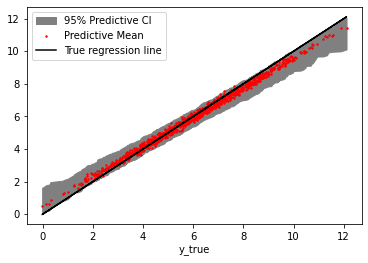

In [ ]:
plt.fill_between(np.sort(y_true), np.sort(predLower), np.sort(predUpper), color="grey", label="95% Predictive CI")
plt.scatter(y_true, predMean, s=2, color="red", label="Predictive Mean")
plt.plot(y_true, y_true, color="black", label="True regression line")
plt.xlabel("y_true")
plt.legend()
plt.show()

# Bayesian Logistic Regression 

A further example for classification is considered here for illustration purposes. 

## Data generation 
In exactly the same manner we here generate some synthetic data. In this case we generate random labels on a binary classification setting using some true linear model to compute the log-odds using the standard sigmoid function. 

In [ ]:
true_coefs = torch.tensor([1., 2.])
data = torch.randn(2000, 2)
dim = 2
labels = dist.Bernoulli(logits=(true_coefs * data).sum(-1)).sample()

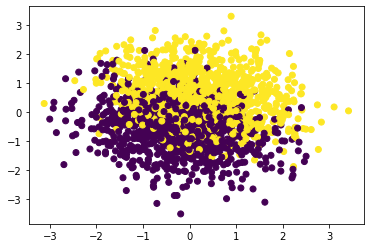

In [ ]:
plt.scatter(data[:,0], data[:,1], c=labels)

## Definition of the model 
In an analogous manner we define an object that mimics the workflow of the model. 

In [ ]:
def model(data):
     coefs_mean = torch.zeros(dim)
     coefs = pyro.sample('beta', dist.Normal(coefs_mean, torch.ones(2)))
     y = pyro.sample('y', dist.Bernoulli(logits=(coefs * data).sum(-1)), obs=labels)
     return y

## Reference Measure

In [ ]:
Sigma_ref = torch.eye(dim)
Sigma_ref_inv = Sigma_ref

## Definition of the Sampler 

In this case, the bound for the Hessian of the previous example does not hold anymore. Although there are ways to bound it here, will consider another strategy. 

We use here numerical optimisation to bound the rates at each step. That is specified with the argument *ihpp_sampler='Corbella'*. It does not need for a bound either, only the refresh rate, the model and the parametres of the reference measure. 

In [ ]:
boomerang_kernel = Boomerang(model,Sigma=Sigma_ref, refresh_rate=1.0, ihpp_sampler='Corbella')
mcmc = MCMC(boomerang_kernel, num_samples=1000, warmup_steps=100)
mcmc.run(data)
print(mcmc.get_samples()['beta'].mean(0))

Sample: 100%|██████████| 1100/1100 [05:06,  3.59it/s, prop. viol=0.000, acc prop=0.010, acc step=0.870, Switch time proposed=0.00023, Bound=2.08e+3]

tensor([0.9312, 1.9582])


In [ ]:
!pip install matplotlib --upgrade

## Posterior Analysis 
In exactly the same manner any Bayesian inference is ready to implement once the convergence of the sample has been assessed with the output as before. 

Here we opt for a more adequated output for classification, providing with the posterior class boundary obtained. 

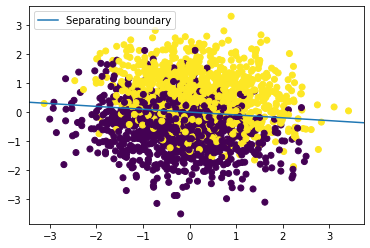

In [ ]:
postMeans = mcmc.get_samples()['beta'].mean(0)
plt.scatter(data[:,0], data[:,1], c=labels)
plt.axline((0, 0), slope=torch.logit(postMeans[0]/postMeans[1]), color='C0', label='Separating boundary')
plt.legend()
plt.show()

# Bayesian Neural Network

Last and most important example in this notebook is on the main character of the project: BAYESIAN NEURAL NETWORKS. 

Not much changes about the sampler itself, but this example will point out the main advantage that this repository provides for further applications. 

## Data generation

Sythetic data is generated targeting the same example as in the report: simulate a noisy sine on $[-\pi, \pi]$. 

In [ ]:
x = torch.linspace(-np.pi, np.pi, 100)
y = torch.sin(x) + torch.normal(0., 0.1, size=(100,))

## Model definition 
We here see the perks of using Pyro and, more specifically, PyTorch. Any torch model is compatible with this implementation on the PDMP since it directly extracts the gradients from the Pyro module. 

This allows for great flexibility since any Neural Network is available in PyTorch. Any architecture of any level of complexity could have been copied and pasted below and it would work in exactly the same fashion. The defintion of the model is also immitating the workflow of the Bayesian skeleton as can be observed. Note that each weight of the neural network needs for specification of a prior distribution as before. 

In [ ]:
from pyro.nn import PyroModule, PyroSample
"BNN" 

class BNN(PyroModule): 
  def __init__(self): 
    super().__init__()
    self.hidden = PyroModule[nn.Linear](1,100)
    self.hidden.weight = PyroSample(dist.Normal(0., 1.).expand([100,1]).to_event(2))
    self.hidden.bias = PyroSample(dist.Normal(0., 1.).expand([100]).to_event(1))

    self.out = PyroModule[nn.Linear](100,1)
    self.out.weight = PyroSample(dist.Normal(0., 1.).expand([1,100]).to_event(2))
    self.out.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))

  def forward(self, x, y=None):  
    x = F.relu(self.hidden(x))
    mu = self.out(x).squeeze()
    #likelihood 
    with pyro.plate("data", x.shape[0]):
      obs = pyro.sample("obs", dist.Normal(mu, 0.1), obs=y)
    return mu    

In [ ]:
import torch.nn.functional as F
import torch.nn as nn
bnn = BNN()
pyro.clear_param_store()

## Reference Measure 
The same guidelines are used for this example with the precaution of using the correct dimension, 301 in this case for the three coefficients associated to each unit (input, output and intercept) plus the intercept of the output unit. 

## Definition of the Sampler 

Here nothing changes, as it is not necessary to define any further quantity to account for any change of the model. Of course that there is no hope for any findings about the Hessian here so numerical optimisation is used. 

In [ ]:
boom_kernel = Boomerang(bnn, Sigma=np.eye(301), refresh_rate = 100, ihpp_sampler='Corbella')
mcmc = MCMC(boom_kernel, num_samples=1000, warmup_steps=1000)
mcmc.run(x.reshape(-1,1), y)

Sample: 100%|██████████| 2000/2000 [26:05,  1.28it/s, prop. viol=0.000, acc prop=0.013, acc step=0.779, Switch time proposed=2.84e-5, Bound=1.11e+4]


## Posterior analysis 
For BNN models comes in handy a further tool provided by Pyro that is the existence of a predictive object that allows to easily calculate the predictive distribution re-using the trace of the simulated process. 

Note that having to re-calculate this would imply fitting each setting sampled for the neural network and evaluating it in each point we want to predict. This would be computationally very expensive. 

Furthermore, this object allows to easily perform Bayesian Inference as in the example below, where some simple bayesian analysis on the uncertainity is provided. 

In [ ]:
# Set model to evaluation mode
bnn.eval()

# Set up predictive distribution
predictive = pyro.infer.Predictive(bnn, posterior_samples = mcmc.get_samples())
## Training predictions
y_train_pred = torch.mean(predictive(x.reshape(-1,1))['obs'], dim=0)


pred_train_summary = summary(predictive(x.reshape(-1,1)))
lower_train = pred_train_summary["obs"]["5%"]
upper_train = pred_train_summary["obs"]["95%"]

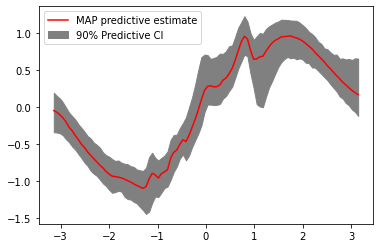

In [ ]:
plt.plot(x, y_train_pred, color="red", label="MAP predictive estimate")
plt.fill_between(x, lower_train, upper_train, color="grey", label="90% Predictive CI")
plt.legend()
plt.show()

Do note that the simulation has not yet converged as only 2000 iterations were performed for illustration purposes. Thus the CI is quite wide in comparision with the noise of the model. 